In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
import pickle
from pmdarima.arima import auto_arima
from prepare_data import PrepareData

/home/jang/ske/da/project-sarimax/training/prepare_data.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("6H")


Get Data

In [2]:
df = PrepareData.df
train_data = PrepareData.train_data()
test_data = PrepareData.test_data()

# Training sarima to predict light 

## EDA

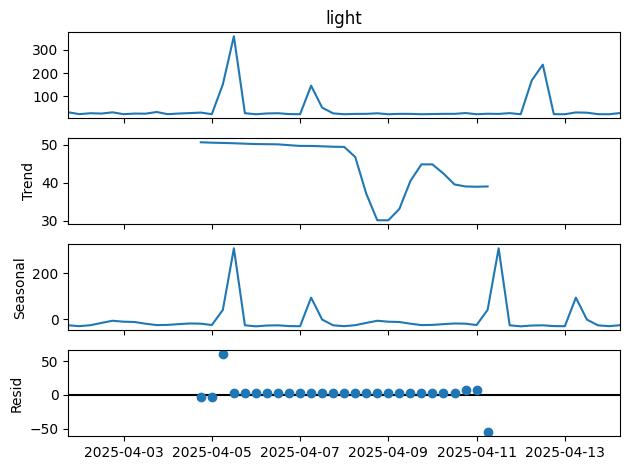

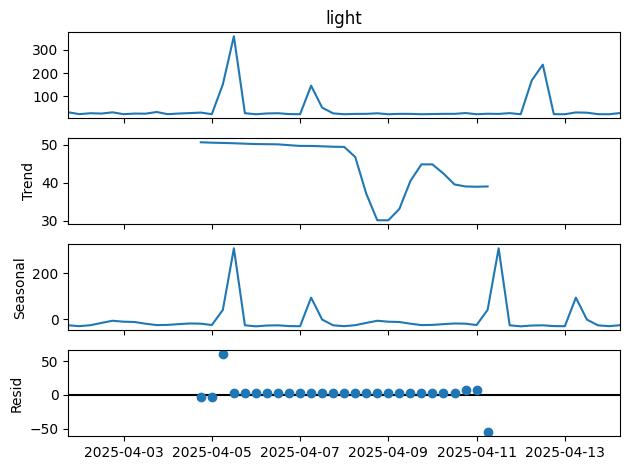

In [3]:
seasonal_decompose(df["light"].interpolate(), model="additive").plot()

### Find the D parameter

In [4]:
result = adfuller(df["light"].dropna(), autolag="AIC")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print("Critial Values:")
    print(f"   {key}, {value}")

ADF Statistic: -4.9845935508555685
p-value: 2.380519453026214e-05
Critial Values:
   1%, -3.5745892596209488
Critial Values:
   5%, -2.9239543084490744
Critial Values:
   10%, -2.6000391840277777


The ADF statistics value is less than 0.05, therefore, it is stationary.

### Find the P parameter

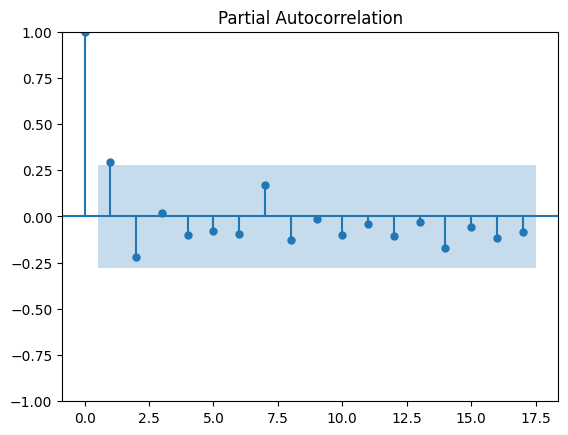

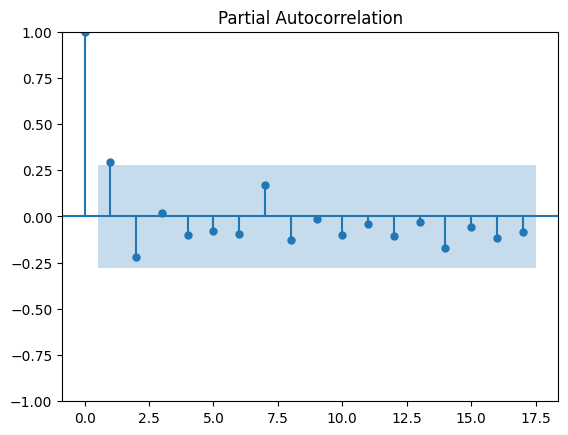

In [5]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["light"].dropna())

The two lags in the front are the most influential, therefore, p = 2

### Find the Q parameter

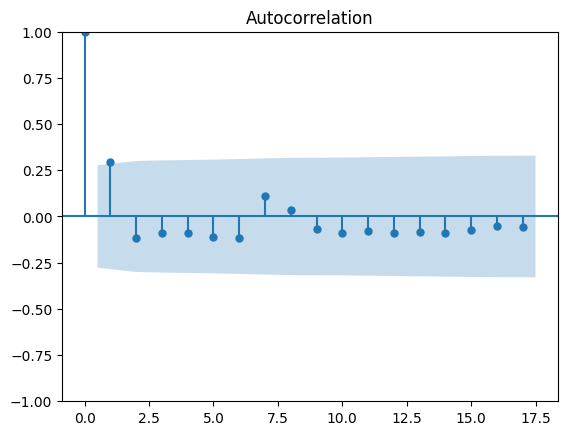

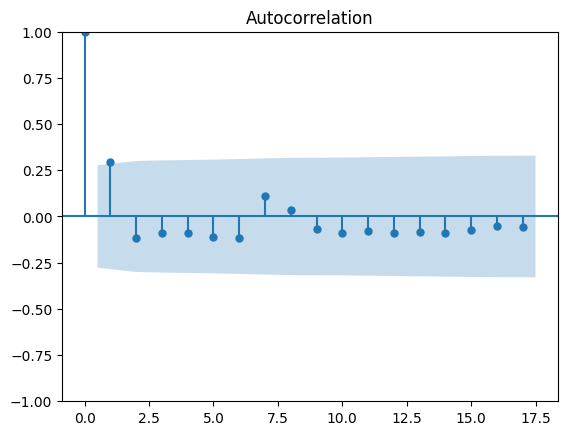

In [6]:
plot_acf(df["light"].dropna())

The graph is not clear, therefore, the q parameter might be 0 or 1

## Pre-Processing

Fill in missing light value (due to server outage)
Use ffill, which replace NULL values with the value from the previous row.

In [7]:
train_data["light"] = train_data["light"].ffill()
test_data["light"] = test_data["light"].ffill()

/tmp/ipykernel_84724/877370702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["light"] = train_data["light"].ffill()
/tmp/ipykernel_84724/877370702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["light"] = test_data["light"].ffill()


## Train the model

In [8]:
# Use auto_arima to find the best model parameters
model = auto_arima(
    train_data["light"],
    seasonal=True,
    m=3,  # Seasonality settings
    d=0,
    D=0,
    max_p=3,
    max_q=3,
    max_P=2,
    max_Q=2,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[3] intercept   : AIC=306.221, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[3] intercept   : AIC=298.976, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[3] intercept   : AIC=301.440, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[3] intercept   : AIC=300.851, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[3]             : AIC=307.136, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[3] intercept   : AIC=300.678, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[3] intercept   : AIC=300.566, Time=0.02 sec


/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(0,0,0)(1,0,1)[3] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[3] intercept   : AIC=299.556, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[3] intercept   : AIC=298.992, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[3] intercept   : AIC=300.443, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[3] intercept
Total fit time: 0.735 seconds


/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
model_temperature = SARIMAX(
    endog=train_data["light"], order=(1, 0, 1), seasonal_order=(1, 0, 1, 3)
)
temperature_results = model_temperature.fit()

steps = len(test_data)

temperature_prediction = temperature_results.get_forecast(
    steps=steps
).predicted_mean
forecast_index = pd.date_range(
    start=test_data.index[0],
    freq=timedelta(days=1),
    periods=int(test_data["light"].count()),
)
temperature_prediction.index = test_data.index[:steps]
temperature_prediction.columns = ["predicted"]

/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


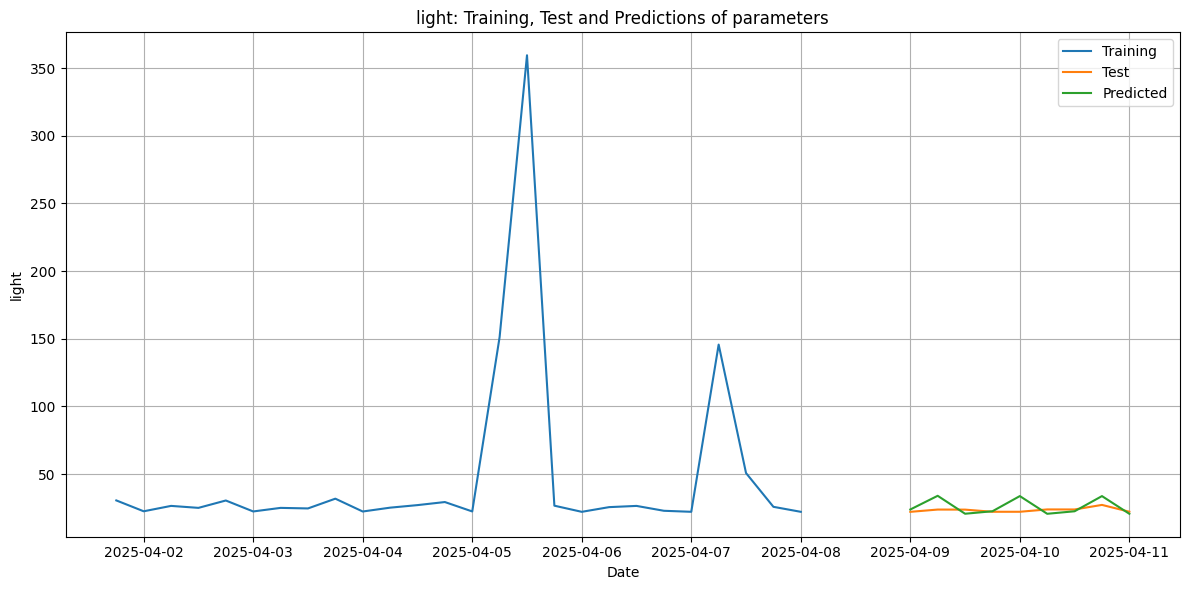

RMSE is :  5.841506279473765


In [10]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["light"], label="Training")
plt.plot(test_data.index, test_data["light"], label="Test")
plt.plot(test_data.index, temperature_prediction, label="Predicted")

plt.legend()
plt.xlabel("Date")
plt.ylabel("light")
plt.title("light: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE is : ", root_mean_squared_error(test_data["light"], temperature_prediction))

## Save the model using pickle

In [11]:
with open("../exports/light_sarima.pkl", "wb") as file:
    pickle.dump(temperature_results, file)